In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from tqdm import tqdm 
import json
from model.models import *
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from huggingface_hub import hf_hub_download
device = 'cuda'
ckpt_path = hf_hub_download(repo_id='yeonwoo378/flowbind', filename='model.pth')
json_path = hf_hub_download(repo_id='yeonwoo378/flowbind', filename='config.json')

In [4]:
import json
ckpt = torch.load(ckpt_path, map_location=device)
with open(json_path, 'r') as f:
    config = json.load(f)
print(ckpt.keys())
ckpt['model_state_dict'].keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'global_step'])


dict_keys(['text', 'image', 'audio'])

In [5]:
from model.mlp_flows import MLPFlow

hidden_dim = config['hidden_dim']
num_layers = config['num_layers']
prior = config['prior']
t_cond = config.get('t_cond', 'add')

scale = config.get("feat_scale", 1.0)
# Load the state dictionaries
text_flow = MLPFlow(in_channels=768, 
                        time_embed_dim=256, 
                        model_channels=hidden_dim,
                        num_res_blocks=num_layers, 
                        prior_method=prior, 
                        t_cond=t_cond,).to(device)
image_flow = MLPFlow(in_channels=768, 
                        time_embed_dim=256, 
                        model_channels=hidden_dim,
                        num_res_blocks=num_layers, 
                        prior_method=prior, 
                        t_cond=t_cond,).to(device)
audio_flow = MLPFlow(in_channels=768, 
                        time_embed_dim=256, 
                        model_channels=hidden_dim,
                        num_res_blocks=num_layers, 
                        prior_method=prior, 
                        t_cond=t_cond,).to(device)
text_flow.load_state_dict(ckpt['model_state_dict']['text'])
image_flow.load_state_dict(ckpt['model_state_dict']['image'])
audio_flow.load_state_dict(ckpt['model_state_dict']['audio'])

text_flow.eval()
image_flow.eval()
audio_flow.eval()

MLPFlow(
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=1152, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1152, out_features=1152, bias=True)
  )
  (input_proj): Linear(in_features=768, out_features=1152, bias=True)
  (res_blocks): ModuleList(
    (0-11): 12 x DiTMLPBlock(
      (emb_layers): Identity()
      (norm): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=1152, out_features=4608, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=4608, out_features=1152, bias=True)
        (drop2): Dropout(p=0, inplace=False)
      )
      (adaLN_modulation): Sequential(
        (0): SiLU()
        (1): Linear(in_features=1152, out_features=3456, bias=True)
      )
    )
  )
  (out): Linear(in_features=1152, out_features=768, bias=True)
  (logvar): Sequential(
    (0): Linear(in_features=768, 

In [7]:
from utils.utils import *
import json
import torchaudio
from torchvision.transforms import ToPILImage

text_enc, text_dec = load_text_enc_and_dec('gemmae', device)
image_enc = load_image_enc('clipvitl14_image', device)
image_dec = load_image_dec('stable-unclip-small', device)
audio_enc = load_audio_enc('clap', device)
audio_dec = load_audio_dec('audioldm-m-full', device)
topil = ToPILImage()

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint /root/.cache/huggingface/hub/models--yeonwoo378--flowbind/snapshots/da8c78db96a0b552a8da737494777e6346e22f15/clap.pt from users.
Load Checkpoint...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The AudioLDMPipeline has been deprecated and will not receive bug fixes or feature updates after Diffusers version 0.33.1. 


In [8]:
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import display

def plot_waveform(waveform, sample_rate):
    waveform = torch.tensor(waveform).mean(axis=0, keepdim=True)  # Convert to mono by averaging channels if necessary
    waveform = waveform.numpy()
    num_frames = waveform.shape[1]
    time_axis = torch.arange(0, num_frames) / sample_rate
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, waveform[0], linewidth=1, color='black')
    plt.grid(False)
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_image(image):
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def prep_image(image_path, normalize=True):
    image = Image.open(image_path).convert('RGB')
    if normalize:
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
        ])
        image = transform(image).unsqueeze(0)
    else:
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        image = transform(image).unsqueeze(0)

    return image

def prep_audio(audio_path, return_sr=False):
    audio, sr = torchaudio.load(audio_path)
    print(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=48000)
    audio = resampler(audio)
    if return_sr:
        return audio, sr
    return audio

## One-to-One Generation

### Text -> Image

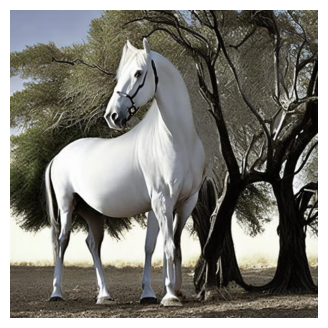

In [23]:
###### INPUTS ######
text = 'A white horse standing next to a tree.'
####################

with torch.no_grad():
    text_feat = text_enc([text]).to(device)

    # Text to Image
    text_z = ode_intergrate(text_flow, text_feat, init_t=1.0, final_t=0.0)
    image_feat = ode_intergrate(image_flow,text_z,  init_t=0.0, final_t=1.0)
    image_hat = image_dec(image_feat)

plot_image(image_hat.float())

### Image -> Text

In [25]:
###### INPUTS ######
image_path = 'figs/monkey.png'
####################

image = prep_image(image_path).to(device)
with torch.no_grad():
    image_feat = image_enc(image).to(device)

    # Image to Text
    image_z = ode_intergrate(image_flow, image_feat, init_t=1.0, final_t=0.0)
    text_feat = ode_intergrate( text_flow,image_z,  init_t=0.0, final_t=1.0)
    text_hat = text_dec(text_feat)[0]
    print("Generated text:", text_hat)

Generated text: A monkey is sitting on top of a rock eating some food.


### Text -> Audio

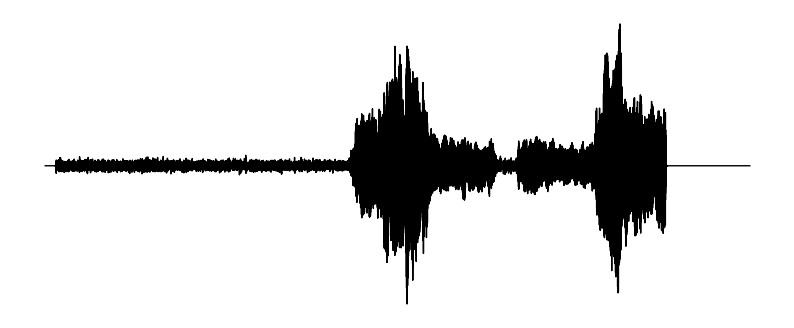

In [10]:
###### INPUTS ######
text = 'a cat meowing and whining'
####################

with torch.no_grad():
    text_feat = text_enc([text]).to(device)

    # Text to Audio
    text_z = ode_intergrate(text_flow, text_feat, init_t=1.0, final_t=0.0)
    audio_feat = ode_intergrate(audio_flow, text_z, init_t=0.0, final_t=1.0)
    audio_hat = audio_dec(audio_feat)
    plot_waveform(audio_hat, sample_rate=48000)
    plt.show()
Audio(audio_hat.squeeze(), rate=16000)
    

### Audio -> Text

In [14]:
###### INPUTS ######
audio_path = 'figs/train.wav'
####################

audio = prep_audio(audio_path).to(device)
with torch.no_grad():
    audio_feat = audio_enc(audio).to(device)

    # Audio to Text
    audio_z = ode_intergrate(audio_flow, audio_feat, init_t=1.0, final_t=0.0)
    text_feat = ode_intergrate( text_flow,audio_z,  init_t=0.0, final_t=1.0)
    text_hat = text_dec(text_feat)[0]
    print("\nGenerated text:", text_hat)

figs/train.wav

Generated text: a train's moving along tracks as the train blows through the cloud


### Image -> Audio

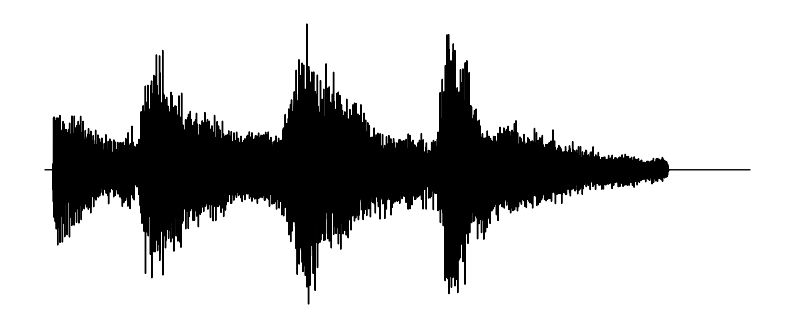

In [16]:
###### INPUTS ######
image_path = 'figs/piano.png'
####################

image = prep_image(image_path).to(device)
with torch.no_grad():
    image_feat = image_enc(image).to(device)

    # Image to Text
    image_z = ode_intergrate(image_flow, image_feat, init_t=1.0, final_t=0.0)
    audio_feat = ode_intergrate(audio_flow, image_z, init_t=0.0, final_t=1.0)
    audio_hat = audio_dec(audio_feat)
    plot_waveform(audio_hat, sample_rate=48000)
    plt.show()
Audio(audio_hat.squeeze(), rate=16000)
    

### Audio -> Image

figs/train.wav


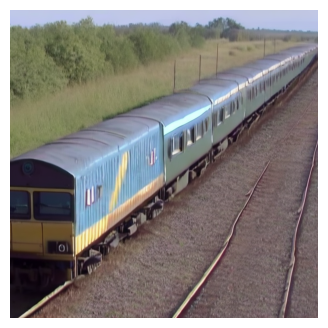

In [37]:
###### INPUTS ######
audio_path = 'figs/train.wav'
####################

audio = prep_audio(audio_path).to(device)
with torch.no_grad():
    audio_feat = audio_enc(audio).to(device)

    # Audio to Image
    audio_z = ode_intergrate(audio_flow, audio_feat, init_t=1.0, final_t=0.0)
    image_feat = ode_intergrate( image_flow,audio_z,  init_t=0.0, final_t=1.0)
    image_hat = image_dec(image_feat).float()
    plot_image(image_hat)

    

## Many-to-One Generation

### (Text + Audio) -> Image

figs/cello.wav


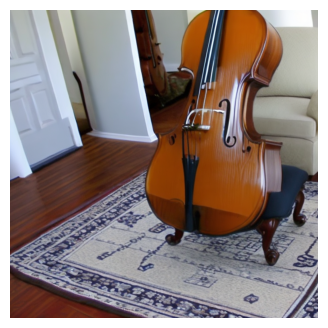

In [43]:
###### INPUTS ######
text = 'A living room with a carpet.'
audio_path = 'figs/cello.wav'
####################

audio = prep_audio(audio_path)

with torch.no_grad():
    text_feat = text_enc([text]).to(device)
    audio_feat = audio_enc(audio).mean(dim=0, keepdim=True).to(device)  
    text_z = ode_intergrate(text_flow, text_feat, init_t=1.0, final_t=0.0)
    audio_z = ode_intergrate(audio_flow, audio_feat, init_t=1.0, final_t=0.0)
    z = (text_z + audio_z) / 2.0
    image_feat = ode_intergrate(image_flow, z, init_t=0.0, final_t=1.0)
    image_hat = image_dec(image_feat)

plot_image(image_hat.float())
plt.show()

### (Image + Audio) -> Text

In [ ]:
###### INPUTS ######
image_path = 'figs/salad.png'
audio_path = 'figs/laughing.wav'
####################

image = prep_image(image_path)
audio = prep_audio(audio_path)
with torch.no_grad():
    audio_feat = audio_enc(audio).mean(dim=0, keepdim=True).to(device)  
    image_feat = image_enc(image).to(device)

    image_z = ode_intergrate(image_flow, image_feat, init_t=1.0, final_t=0.0)
    audio_z = ode_intergrate(audio_flow, audio_feat, init_t=1.0, final_t=0.0)

    z = (image_z + audio_z) / 2.0
    text_feat = ode_intergrate(text_flow, z, init_t=0.0, final_t=1.0)
    text_hat = text_dec(text_feat)[0]
    
print(f'\nGenerated Text: {text_hat}')

### (Text + Image) -> Image

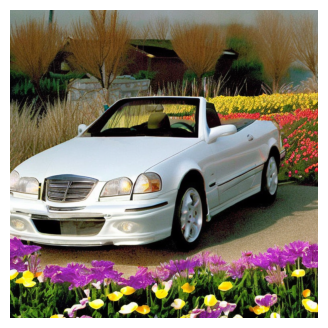

In [30]:
###### INPUTS ######
text = 'A quiet gardent with colorful flowers blooming.'
image_path = 'figs/car.jpg'
####################

image = prep_image(image_path)
with torch.no_grad():
    text_feat = text_enc([text]).to(device)
    image_feat = image_enc(image).to(device)
    text_z = ode_intergrate(text_flow, text_feat, init_t=1.0, final_t=0.0)
    image_z = ode_intergrate(image_flow, image_feat, init_t=1.0, final_t=0.0)
    z = (text_z + image_z) / 2.0
    image_feat = ode_intergrate(image_flow, z, init_t=0.0, final_t=1.0)
    image_hat = image_dec(image_feat)

plot_image(image_hat.float())
plt.show()

## One-to-Many Generation

### Text -> (Image + Audio)

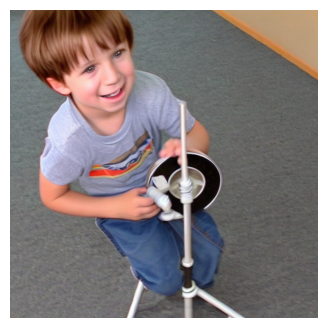

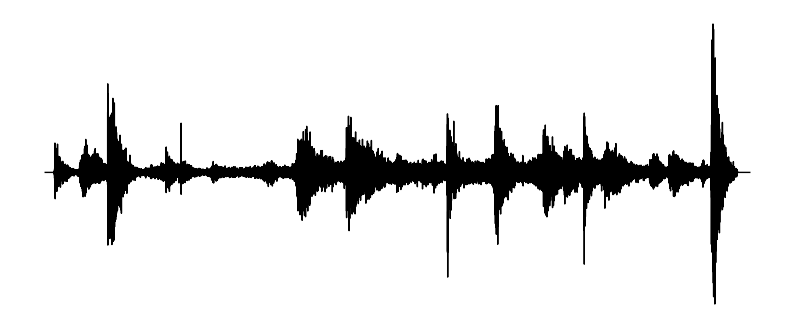

In [69]:
###### INPUTS ######
text = 'a boy is playing the drums'
####################

with torch.no_grad():
    text_feat = text_enc([text]).to(device)

    # Text to Image
    text_z = ode_intergrate(text_flow, text_feat, init_t=1.0, final_t=0.0)
    image_feat = ode_intergrate(image_flow,text_z,  init_t=0.0, final_t=1.0)
    audio_feat = ode_intergrate(audio_flow, text_z, init_t=0.0, final_t=1.0)

    image_hat = image_dec(image_feat)
    audio_hat = audio_dec(audio_feat)

plot_image(image_hat.float())
plot_waveform(audio_hat, sample_rate=16000)
display(Audio(audio_hat.squeeze(), rate=16000))

### Image -> (Text + Audio)

Generated Text: The dog is smiling with its mouth open.


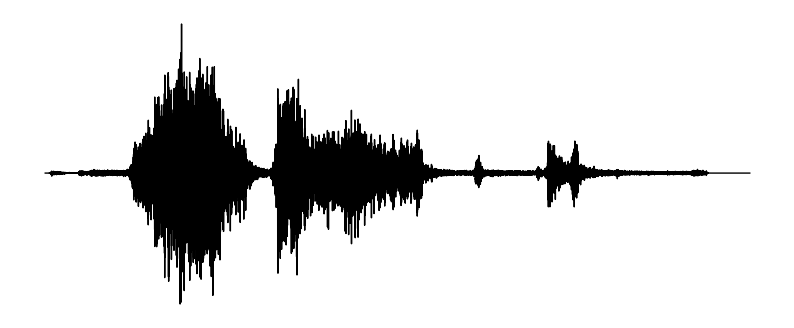

In [63]:
###### INPUTS ######
image_path = 'figs/dog.png'
####################
image = prep_image(image_path)
with torch.no_grad():
    image_feat = image_enc(image).to(device)

    # Text to Image
    image_z = ode_intergrate(image_flow, image_feat, init_t=1.0, final_t=0.0)
    text_feat = ode_intergrate(text_flow, image_z, init_t=0.0, final_t=1.0)
    audio_feat = ode_intergrate(audio_flow, image_z, init_t=0.0, final_t=1.0)

    text_hat = text_dec(text_feat)[0]
    audio_hat = audio_dec(audio_feat)


print(f'Generated Text: {text_hat}')
plot_waveform(audio_hat, sample_rate=16000)
plt.show()  
display(Audio(audio_hat.squeeze(), rate=16000))